<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/Probability_Calibration/01_Probability_Calibration_Model_No_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.calibration import (
    CalibratedClassifierCV,
    calibration_curve)

from sklearn.model_selection import (
    train_test_split, GridSearchCV)

from sklearn.metrics import brier_score_loss, accuracy_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# **Info**
---
**@By:** Steven Bernal

**@Nickname:** Kaiziferr

**@Git:** https://github.com/Kaiziferr

The objective of this exercise is to validate the model calibration process when the focus is on probabilities. A no-ensemble binary classification model will be applied. The methods 'CalibratedClassifierCV', 'calibration_curve' and 'brier_score_loss' will be used. The calibrated model will be validated without adjustment, with adjustment, and without calibration.

# **Settings**
---

In [2]:
random_seed=12345
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

# **Data**
---

Synthetic data will be generated

In [3]:
def data_generator(**kward):
  X, y = make_classification(
      random_state = random_seed,
      **kward
  )
  return X, y

# **Calibration**
---

## **Model No ensemble**


**Data**

A synthetic dataset of 1000 records will be generated, with 20 features, of which 15 will be informative and 5 will be redundant. It will be a binary classification dataset, with a classification error rate of 15% and a separation of 5.

In [4]:
X, y = data_generator(
    **{
      "n_samples":1000,
      "n_features":20,
      "n_informative":15,
      "n_redundant":5,
      "n_clusters_per_class":5,
      "n_classes":2,
      "flip_y":0.15,
      "class_sep":5,
      }
)

**Data Split**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=random_seed
)

**Model No Fit**

The model will be a  no-ensemble model and will not be trained. The model will is Decition Tree. A DecisionTreeClassifier is instantiated with basic configurations and without fit. The configuration is 8 max depth and rest default params.

In [6]:
model_tree = DecisionTreeClassifier(
    max_depth=8
)

The model's probabilities are calibrated using the 'CalibratedClassifierCV' function with 10 'cv' and the 'sigmoid' method.

In [7]:
calibrate_model_tree = CalibratedClassifierCV(
    estimator=model_tree,
    method='sigmoid',
    cv=10,
    ensemble=False,
)
calibrate_model_tree.fit(X_train, y_train)

CalibratedClassifierCV(cv=10, ensemble=False,
                       estimator=DecisionTreeClassifier(max_depth=8))

The test probabilities are obtained.

In [8]:
calibreated_probs_test = calibrate_model_tree.predict_proba(X_test)

**Model Uncalibrated**



The previously configured, uncalibrated model is fitted. Then, probability predictions are made. This is done to compare the model's calibration


In [9]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

The test probabilities are obtained.



In [10]:
model_probs_test = model_tree.predict_proba(X_test)

**Model-Fit**

In [11]:
calibrate_model_tree_prefit = CalibratedClassifierCV(
    estimator=model_tree,
    method='sigmoid',
    cv="prefit",
    ensemble=False,
)
calibrate_model_tree_prefit.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit', ensemble=False,
                       estimator=DecisionTreeClassifier(max_depth=8))

The test probabilities are obtained.



In [12]:
calibreated_probs_test_prefit = calibrate_model_tree_prefit.predict_proba(X_test)

Having the probabilities, a comparison is made between the calibrated model no-fit, the unicalibrated model and model fit

It will be assumed that class 1 is the class of interest.


One class or another, the number of selected 'bins' may be smaller, as those with no probability will collapse. To get a good idea of how many groups can be obtained, a histogram is used to determine how many bins are suitable for grouping the average probabilities. To be consistent in magnitude, the appropriate binning must be chosen, and it should be the same for all models.

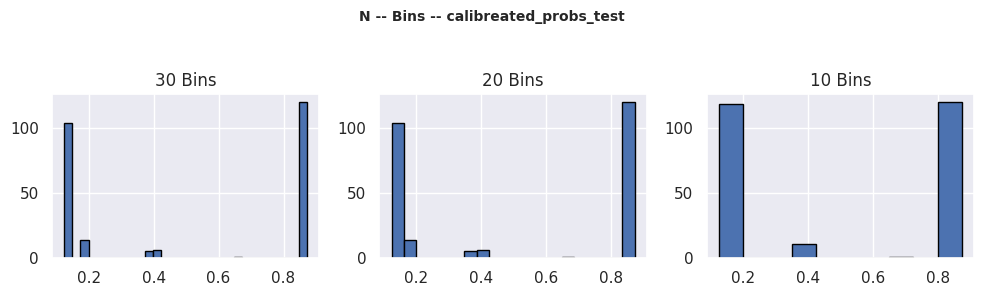

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].hist(calibreated_probs_test[:,1], bins=30, edgecolor='black')
ax[0].set_title('30 Bins')

ax[1].hist(calibreated_probs_test[:,1], bins=20, edgecolor='black')
ax[1].set_title('20 Bins')
ax[2].hist(calibreated_probs_test[:,1], bins=10, edgecolor='black')
ax[2].set_title('10 Bins')
fig.tight_layout()
plt.subplots_adjust(top = 0.7)
fig.suptitle('N -- Bins -- calibreated_probs_test', fontsize = 10, fontweight = "bold");
plt.show()

- The number of 'bins' is set to 10, as a more accurate estimation can be obtained visually.


To be consistent with the visualization and comparison, the number 10 will be selected for the remaining functions to obtain a calibration curve.

In [14]:
prob_true_cali_target, prob_pred_cali_target = calibration_curve(y_test, calibreated_probs_test[:,1], n_bins=10)
prob_true_model_target, prob_pred_model_target = calibration_curve(y_test, model_probs_test[:,1], n_bins=10)
prob_true_cali_target_prefit, prob_pred_cali_target_prefit = calibration_curve(y_test, calibreated_probs_test_prefit[:,1], n_bins=10)

The difference between the predicted probability and the actual outcome of the calibrated model is very close to zero, which means the model is reliable and making good predictions.

In [16]:
brier_score = brier_score_loss(y_test, calibreated_probs_test[:, 1])
brier_score

0.13563544835933664

However, the uncalibrated model also tends to be well-tuned, with the difference being minimal.

In [17]:
brier_score = brier_score_loss(y_test, model_probs_test[:, 1])
brier_score

0.15859149764218775

The difference between the predicted probability and the actual result of the pre-trained calibrated model is closer to zero than to one; it is below 0.5, which means the model is reliable and makes good predictions.

In [18]:
brier_score = brier_score_loss(y_test, calibreated_probs_test_prefit[:, 1])
brier_score

0.15388154286948447

The uncalibrated model for the dataset is good, as is the pre-trained calibrated model, which is better than the former but with a very minimal difference. However, the unadjusted calibrated model is better than the previous ones, and in a context where probabilities are critical, the difference can be significant.

This graph will allow the comparison of the real probability line versus the calibrated probability line for each of the models.

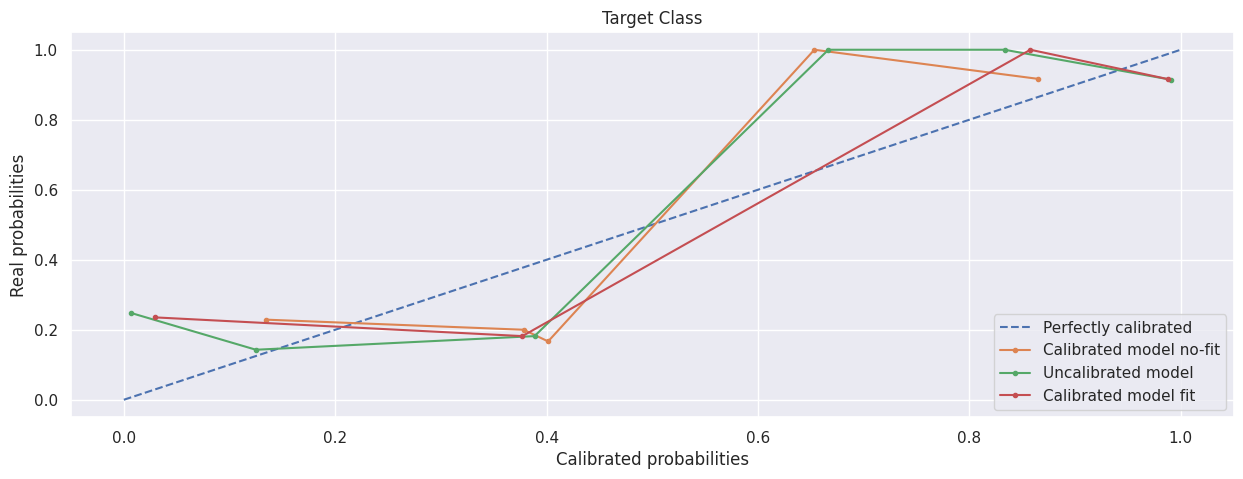

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.plot(prob_pred_cali_target, prob_true_cali_target, marker='.', label='Calibrated model no-fit')
plt.plot(prob_pred_model_target, prob_true_model_target, marker='.', label='Uncalibrated model')
plt.plot(prob_pred_cali_target_prefit , prob_true_cali_target_prefit, marker='.', label='Calibrated model fit')
plt.title("Target Class")
plt.legend(loc='lower right')
plt.xlabel('Calibrated probabilities')
plt.ylabel('Real probabilities')
plt.show()

Analyzing the graph with the same probability separation, the models show a similar behavior, somewhat close to the theoretically perfect model represented by the diagonal line.

The diagonal line is used as a reference to represent a perfectly calibrated model. The model closest to that perfection is the unadjusted but calibrated model Represented by the orange line.

For the next analysis, the most prominent probability points of each model will be examined.



In [24]:
prob_true_cali_target_prefit, prob_pred_cali_target_prefit

(array([0.23529412, 0.18181818, 1.        , 0.91596639]),
 array([0.02972996, 0.37708384, 0.85781001, 0.98816206]))

The uncalibrated model (green line) is very close to the diagonal line, which means that calibration might not be necessary. However, some significant probability points will be described:

- For a group of records with a real probability of 19% of being the target class, the model might predict 39%. The model is overestimating the probability.

- For a group of records with a real probability of 100% of being the target class, the model might predict 83%. The model is underestimating the probability.

The calibrated model (orange line) is closer to the diagonal than the uncalibrated model. Some significant probability points are:

- For a group of records with a real probability of 17% of being the target class, the model might predict 40%. The model is overestimating the probability.

- For a group of records with a real probability of 100% of being the target class, the model might predict 65%. The model is underestimating the probability.

The adjusted and calibrated model (red line) is very close to the diagonal line; however, the previous options are better, although the difference is minimal.

- For a group of records with a real probability of 18% of being the target class, the model might predict 37%. The model is overestimating the probability.

- For a group of records with a real probability of 100% of being the target class, the model might predict 86%. The model is underestimating the probability.

Since the dataset has minimal imbalance, the 'Precision' option was used to validate performance.

In [25]:
recall_score(y_test, calibrate_model_tree.predict(X_test), labels=[1])

0.7928571428571428

In [26]:
recall_score(y_test, model_tree.predict(X_test),  labels=[1])

0.7857142857142857

In [28]:
recall_score(y_test, calibrate_model_tree_prefit.predict(X_test),  labels=[1])

0.7857142857142857

It is evident that all the models have optimal performance, with all being close to 80% for the prediction of two classes. The best model is the untrained calibrated model.

# **Info**
---
**@By:** Steven Bernal

**@Nickname:** Kaiziferr

**@Git:** https://github.com/Kaiziferr